# Logistic Regression

In [1]:
# torch
import torch 
import torch.nn as nn
import torch.optim as optim  
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
) 

# other
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
from skimage import io
import time
import copy
import cv2
from tqdm import tqdm

warnings.filterwarnings("ignore")

# helper functions
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix, compute_accuracy, cal_pre_rec
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import UnNormalize
from data_loading_functions import split_train_test_loaders, show_img, convert_lab
from helper_Gradcam import store_gradcam_image



# Settings

In [2]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
NUM_EPOCHS = 50

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

# Load Data and Preprocessing 

In [3]:
dataset_path = '.\\COVID-19_Radiography_Dataset'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path, batch_size= BATCH_SIZE)

# Display Images

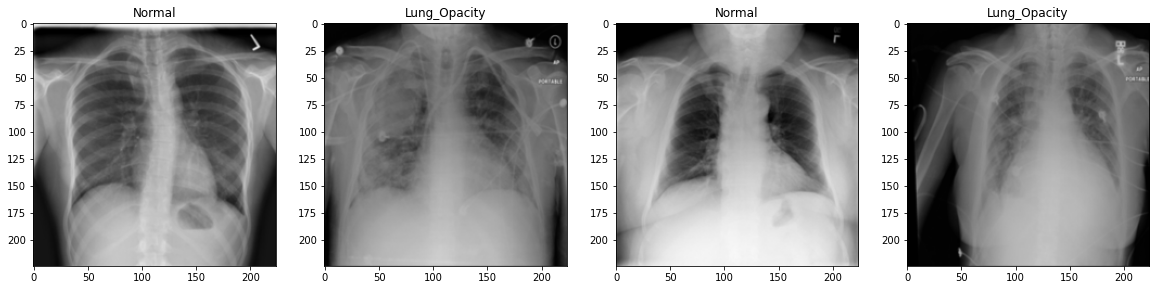

In [4]:
show_img(dataset_path= dataset_path, train= False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


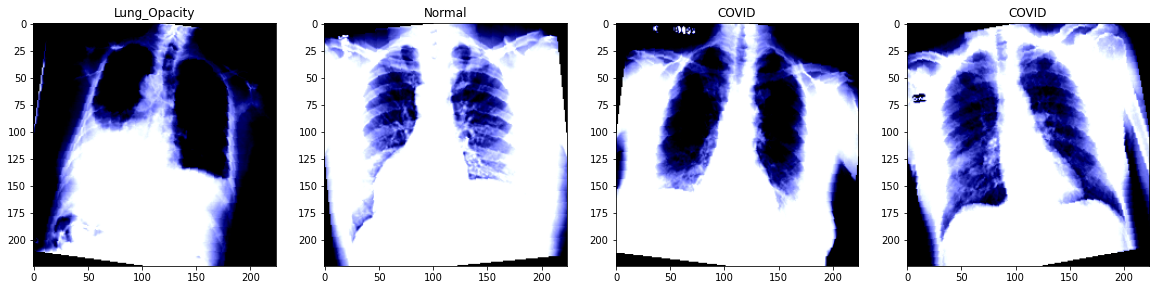

In [5]:
show_img(dataset_path= dataset_path, train= True) 

# Train Model

In [6]:
# Define model
class LogisticRegression(torch.nn.Module):

    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(224*224*3, 4)
        
    def forward(self, x):
        logits = self.linear(x.view(-1, 3*224*224))
        probas = F.sigmoid(logits)
        return probas

model_ft = LogisticRegression(4)
# Train
torch.manual_seed(RANDOM_SEED)
model_ft.to(DEVICE)
optimizer = torch.optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list_ft, train_acc_list_ft, valid_acc_list_ft = train_model(num_epochs = NUM_EPOCHS, model = model_ft, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/050 | Batch 0000/0265 | Loss: 1.4198
Epoch: 001/050 | Batch 0050/0265 | Loss: 1.2252
Epoch: 001/050 | Batch 0100/0265 | Loss: 1.2317
Epoch: 001/050 | Batch 0150/0265 | Loss: 1.2326
Epoch: 001/050 | Batch 0200/0265 | Loss: 1.2159
Epoch: 001/050 | Batch 0250/0265 | Loss: 1.2122
Epoch: 001/050 | Train: 55.82% | Validation: 55.46%
Time elapsed: 3.15 min
Epoch: 002/050 | Batch 0000/0265 | Loss: 1.1641
Epoch: 002/050 | Batch 0050/0265 | Loss: 1.1445
Epoch: 002/050 | Batch 0100/0265 | Loss: 1.1794
Epoch: 002/050 | Batch 0150/0265 | Loss: 1.2014
Epoch: 002/050 | Batch 0200/0265 | Loss: 1.1785
Epoch: 002/050 | Batch 0250/0265 | Loss: 1.0972
Epoch: 002/050 | Train: 57.67% | Validation: 58.10%
Time elapsed: 5.30 min
Epoch: 003/050 | Batch 0000/0265 | Loss: 1.1688
Epoch: 003/050 | Batch 0050/0265 | Loss: 1.2039
Epoch: 003/050 | Batch 0100/0265 | Loss: 1.2163
Epoch: 003/050 | Batch 0150/0265 | Loss: 1.0899
Epoch: 003/050 | Batch 0200/0265 | Loss: 1.1547
Epoch: 003/050 | Batch 0250/0265 |

Epoch: 023/050 | Batch 0200/0265 | Loss: 1.1228
Epoch: 023/050 | Batch 0250/0265 | Loss: 0.9947
Epoch: 023/050 | Train: 61.59% | Validation: 61.74%
Time elapsed: 48.25 min
Epoch: 024/050 | Batch 0000/0265 | Loss: 1.0454
Epoch: 024/050 | Batch 0050/0265 | Loss: 1.0235
Epoch: 024/050 | Batch 0100/0265 | Loss: 1.1892
Epoch: 024/050 | Batch 0150/0265 | Loss: 1.0832
Epoch: 024/050 | Batch 0200/0265 | Loss: 1.0923
Epoch: 024/050 | Batch 0250/0265 | Loss: 1.0730
Epoch: 024/050 | Train: 61.47% | Validation: 61.08%
Time elapsed: 50.25 min
Epoch: 025/050 | Batch 0000/0265 | Loss: 1.1348
Epoch: 025/050 | Batch 0050/0265 | Loss: 1.1990
Epoch: 025/050 | Batch 0100/0265 | Loss: 1.1594
Epoch: 025/050 | Batch 0150/0265 | Loss: 1.0582
Epoch: 025/050 | Batch 0200/0265 | Loss: 1.0017
Epoch: 025/050 | Batch 0250/0265 | Loss: 1.1843
Epoch: 025/050 | Train: 59.92% | Validation: 59.66%
Time elapsed: 52.31 min
Epoch: 026/050 | Batch 0000/0265 | Loss: 1.0802
Epoch: 026/050 | Batch 0050/0265 | Loss: 1.0299
Epoc

Epoch: 046/050 | Batch 0050/0265 | Loss: 1.1527
Epoch: 046/050 | Batch 0100/0265 | Loss: 1.1441
Epoch: 046/050 | Batch 0150/0265 | Loss: 1.1554
Epoch: 046/050 | Batch 0200/0265 | Loss: 1.1279
Epoch: 046/050 | Batch 0250/0265 | Loss: 1.1222
Epoch: 046/050 | Train: 60.12% | Validation: 58.81%
Time elapsed: 95.01 min
Epoch: 047/050 | Batch 0000/0265 | Loss: 1.1694
Epoch: 047/050 | Batch 0050/0265 | Loss: 1.0500
Epoch: 047/050 | Batch 0100/0265 | Loss: 1.1474
Epoch: 047/050 | Batch 0150/0265 | Loss: 1.1191
Epoch: 047/050 | Batch 0200/0265 | Loss: 1.1329
Epoch: 047/050 | Batch 0250/0265 | Loss: 0.9836
Epoch: 047/050 | Train: 61.97% | Validation: 61.50%
Time elapsed: 97.03 min
Epoch: 048/050 | Batch 0000/0265 | Loss: 1.1650
Epoch: 048/050 | Batch 0050/0265 | Loss: 1.0681
Epoch: 048/050 | Batch 0100/0265 | Loss: 1.1849
Epoch: 048/050 | Batch 0150/0265 | Loss: 1.0463
Epoch: 048/050 | Batch 0200/0265 | Loss: 1.1619
Epoch: 048/050 | Batch 0250/0265 | Loss: 1.1235
Epoch: 048/050 | Train: 57.42% |

In [15]:
torch.save(model_ft, os.path.join('.\\models', 'Logistic_regression_oldnorm.pth'))

# Evaluation 

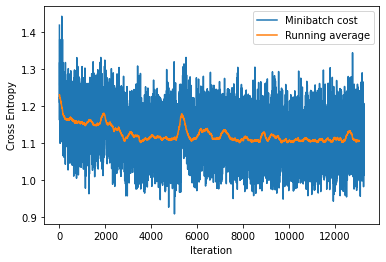

In [7]:
plt.plot(minibatch_loss_list_ft, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list_ft, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

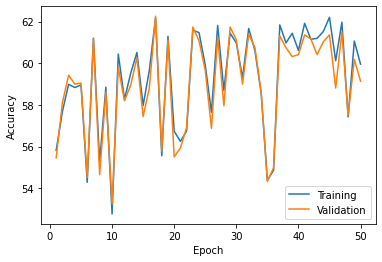

In [8]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list_ft, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_ft, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


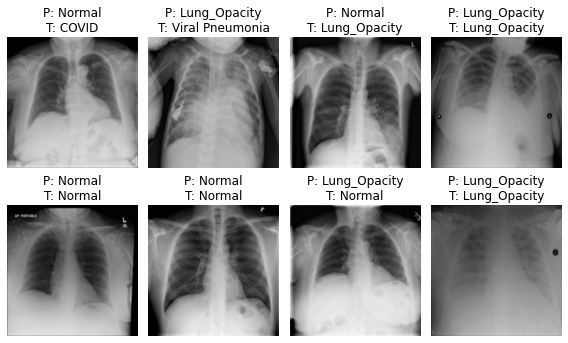

In [9]:
model_ft.cpu()
unnormalizer = UnNormalize((0.4363, 0.4328, 0.3291), (0.2129, 0.2075, 0.2038))
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

show_examples(model=model_ft, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

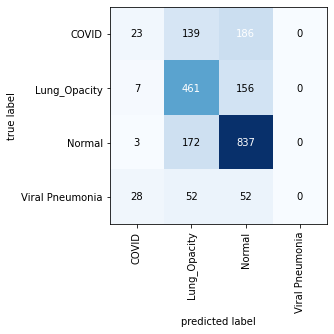

In [10]:
# model_ft.cpu()
model_ft.to(DEVICE)
mat = compute_confusion_matrix(model=model_ft, data_loader=test_loader, device=DEVICE)
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

# Precision, Recall, F1

In [13]:
cal_pre_rec(mat)

COVID => Precision: 25.86%, Recall: 28.75%, F1: 27.23%
-----------------
Lung_Opacity => Precision: 53.85%, Recall: 70.59%, F1: 61.09%
-----------------
Normal => Precision: 88.04%, Recall: 67.14%, F1: 76.19%
-----------------
Viral Pneumonia => Precision: 0.0%, Recall: nan%, F1: nan%
-----------------
